In [40]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
import pandas as pd
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [41]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [42]:
# train_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Training'
# test_path = '/content/drive/MyDrive/Colab Notebooks/brain_tumor_detection/brain_tumor_dataset/Testing'
train_path = 'brain_tumor_dataset/Training'
test_path = 'brain_tumor_dataset/Testing'


In [43]:
train_df = train_df(train_path)
test_df = test_df(test_path)
valid_df, test_df = train_test_split(test_df, train_size=0.5, random_state=20, stratify=test_df['Class'])
valid_df

,Class Path,Class
991,brain_tumor_dataset/Testing/glioma/Te-gl_0129.jpg,glioma
1023,brain_tumor_dataset/Testing/meningioma/Te-me_0...,meningioma
61,brain_tumor_dataset/Testing/pituitary/Te-pi_01...,pituitary
1078,brain_tumor_dataset/Testing/meningioma/Te-me_0...,meningioma
814,brain_tumor_dataset/Testing/glioma/Te-gl_0219.jpg,glioma
...,...,...
764,brain_tumor_dataset/Testing/glioma/Te-gl_0136.jpg,glioma
554,brain_tumor_dataset/Testing/notumor/Te-no_0206...,notumor
978,brain_tumor_dataset/Testing/glioma/Te-glTr_000...,glioma
1199,brain_tumor_dataset/Testing/meningioma/Te-me_0...,meningioma


In [44]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 128
img_size = (224, 224)

_gen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(rescale=1/255)


train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


In [28]:
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {test_gen.samples}")
print(f"Validation samples: {valid_gen.samples}")

Training samples: 5712
Validation samples: 656
Validation samples: 655


In [45]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

model_temp = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
model_temp.trainable = False

model = Sequential()
model.add(model_temp)
model.add(GlobalAveragePooling2D())
model.add(Dense(4, activation='softmax'))
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.99)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 3,844 (15.02 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [46]:
import time
start_time = time.time()

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=valid_gen
)

# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.samples // train_generator.batch_size,
#     epochs=10,
#     validation_data=test_generator,
#     validation_steps=test_generator.samples // test_generator.batch_size
# )

# model.save('MobileNetV350epochs64batch_size')
end_time = time.time()

print('The training of the Transfer Learning model took',round((end_time-start_time)/60),'minutes.')

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 40s 829ms/step - accuracy: 0.2835 - loss: 1.3722 - val_accuracy: 0.3573 - val_loss: 1.3008
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 792ms/step - accuracy: 0.4043 - loss: 1.2537 - val_accuracy: 0.3603 - val_loss: 1.2814
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 793ms/step - accuracy: 0.4288 - loss: 1.2188 - val_accuracy: 0.3908 - val_loss: 1.2816
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 782ms/step - accuracy: 0.4647 - loss: 1.2012 - val_accuracy: 0.4260 - val_loss: 1.2541
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 36s 784ms/step - accuracy: 0.4817 - loss: 1.1927 - val_accuracy: 0.4336 - val_loss: 1.2393
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 770ms/step - accuracy: 0.4884 - loss: 1.1708 - val_accuracy: 0.4412 - val_loss: 1.2330
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 776ms/step - accuracy: 0.5112 - loss: 1.1493 - val_accuracy: 0.4366 - val_loss: 1.2455
Epoch 8/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 35s 770ms/step - accuracy: 0.5129 - loss: 1.1412 - val_accu

In [47]:
# val_loss, val_accuracy = model.evaluate(x_test, y_test)

test_loss, test_accuracy = model.evaluate(
    test_gen,
    # steps=test_generator.samples // test_generator.batch_size
)

print(f"Test Loss: {round(test_loss,4)}")
print(f"Test Accuracy: {round(100*test_accuracy,2)}%")


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.6104 - loss: 0.9879
Test Loss: 0.9393
Test Accuracy: 62.96%


In [13]:
print(history.history)

{'accuracy': [0.26120448112487793], 'loss': [1.3917195796966553], 'val_accuracy': [0.30839693546295166], 'val_loss': [1.379621148109436]}


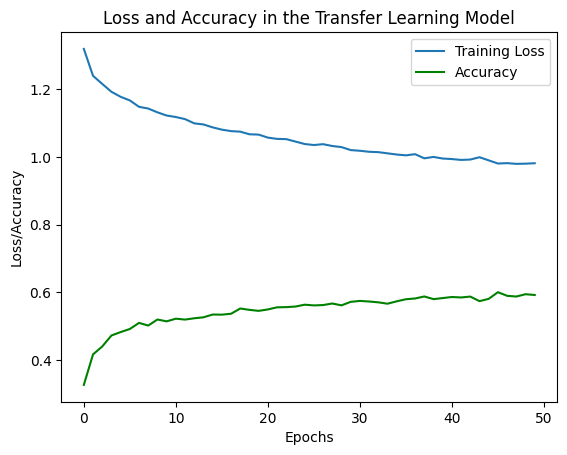

In [50]:
plt.plot(history.history['loss'], label='Training Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history["accuracy"],label='Accuracy' ,c="green")
plt.title("Loss and Accuracy in the Transfer Learning Model")
plt.ylabel("Loss/Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predicted_labels = np.argmax(model.predict(test_gen),axis=1)

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step


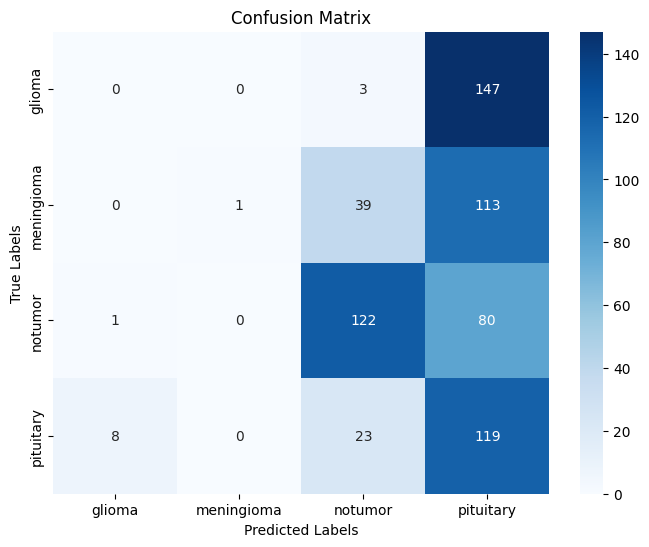

In [37]:
import seaborn as sns

true_labels = test_gen.classes

cm = confusion_matrix(true_labels, predicted_labels)

# Step 4: Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
